In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ioPThccr9WKNC9GFwOzA")
project = rf.workspace("new-walx8").project("eic")
version = project.version(3)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to EIC-3 in folder:: 100%|██████████| 1502/1502 [00:00<00:00, 9188.85it/s]


In [ ]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# -------------------------
# CONFIGURATION
# -------------------------
TRAIN_DATA_PATH = '/content/EIC-3/train'  # Path to the training dataset
TEST_DATA_PATH = '/content/EIC-3/test'  # Path to the test dataset
MODEL_SAVE_PATH = 'resnet101_transfer_learning1.pth'  # Path to save the trained model
BATCH_SIZE = 32
NUM_CLASSES = 3  # Replace with the number of classes in your dataset
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
CLASS_NAMES = ['BERDIRI', 'DUDUK', 'TIDUR']  # Replace with your actual class names

In [ ]:
# -------------------------
# DATA PREPARATION
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# -------------------------
# MODEL SETUP
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet101
model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # Modify the last layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 173MB/s]


In [ ]:
# -------------------------
# TRAINING LOOP
# -------------------------
model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {running_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved to:", MODEL_SAVE_PATH)

Epoch [1/25], Loss: 0.0835
Epoch [2/25], Loss: 0.0186
Epoch [3/25], Loss: 0.0081
Epoch [4/25], Loss: 0.0002
Epoch [5/25], Loss: 0.0002
Epoch [6/25], Loss: 0.0001
Epoch [7/25], Loss: 0.0001
Epoch [8/25], Loss: 0.0001
Epoch [9/25], Loss: 0.0000
Epoch [10/25], Loss: 0.0000
Epoch [11/25], Loss: 0.0000
Epoch [12/25], Loss: 0.0000
Epoch [13/25], Loss: 0.0001
Epoch [14/25], Loss: 0.0000
Epoch [15/25], Loss: 0.0000
Epoch [16/25], Loss: 0.0000
Epoch [17/25], Loss: 0.0000
Epoch [18/25], Loss: 0.0000
Epoch [19/25], Loss: 0.0000
Epoch [20/25], Loss: 0.0000
Epoch [21/25], Loss: 0.0000
Epoch [22/25], Loss: 0.0000
Epoch [23/25], Loss: 0.0000
Epoch [24/25], Loss: 0.0000
Epoch [25/25], Loss: 0.0000
Model saved to: resnet101_transfer_learning1.pth


In [ ]:
# -------------------------
# TESTING LOOP
# -------------------------
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

Classification Report:
              precision    recall  f1-score   support

     BERDIRI       1.00      1.00      1.00        19
       DUDUK       1.00      1.00      1.00        21
       TIDUR       1.00      1.00      1.00        21

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



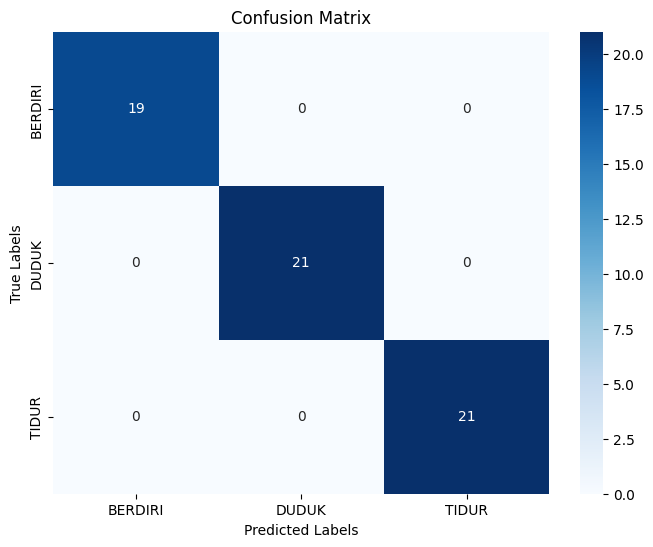

In [ ]:
# -------------------------
# METRICS AND CONFUSION MATRIX
# -------------------------
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=test_dataset.classes)

print("Classification Report:")
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()